In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('bengaluru_house_prices.csv')
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [4]:
df.shape

(13320, 9)

<h1 style="color:blue; font-weight:bold;"> Data Cleaning </h1>

Arbitrarily, I choose to remove the columns 'availability' and 'society' which I don't find relevant for our prediction problem.

In [5]:
df1 = df.drop(['availability', 'society'], axis = 'columns')
df1.head()

,area_type,location,size,total_sqft,bath,balcony,price
0,Super built-up Area,Electronic City Phase II,2 BHK,1056,2.0,1.0,39.07
1,Plot Area,Chikka Tirupathi,4 Bedroom,2600,5.0,3.0,120.00
2,Built-up Area,Uttarahalli,3 BHK,1440,2.0,3.0,62.00
3,Super built-up Area,Lingadheeranahalli,3 BHK,1521,3.0,1.0,95.00
4,Super built-up Area,Kothanur,2 BHK,1200,2.0,1.0,51.00


In [6]:
df1.isna().sum()

area_type       0
location        1
size           16
total_sqft      0
bath           73
balcony       609
price           0
dtype: int64

Since the dataset is big enough, I choose to get rid of the NaN values.

In [7]:
df2 = df1.dropna()
df2.isna().sum()

area_type     0
location      0
size          0
total_sqft    0
bath          0
balcony       0
price         0
dtype: int64

Now, we will study some columns which may contain outliers or other wrong features.

In [8]:
df2['size'].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '3 Bedroom', '1 BHK', '1 RK',
       '4 BHK', '1 Bedroom', '2 Bedroom', '6 Bedroom', '8 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '11 Bedroom', '43 Bedroom',
       '14 BHK', '8 BHK', '12 Bedroom', '10 Bedroom', '13 BHK'],
      dtype=object)

Here we can notice that the bedroom counting is not homogeneous. For instance, a house with 3 bedrooms can be written '3 BHK' or '3 Bedroom'. We need to fix this in order to allow the predictions.

In [9]:
def extract_nb_bedrooms(size : str) -> int :
    return int(size.split(' ')[0])

In [10]:
df3 = df2.copy()
df3['bedroom_formated'] = df2['size'].apply(extract_nb_bedrooms)

In [11]:
df3 = df3.drop('size', axis = 'columns')

In [12]:
df3['total_sqft']

0        1056
1        2600
2        1440
3        1521
4        1200
         ... 
13314    1715
13315    3453
13317    1141
13318    4689
13319     550
Name: total_sqft, Length: 12710, dtype: object

Some houses are listed with a range for the surface area instead of a unique value or with a different unit. We will replace these ranges with the mean value, and convert in the correct unit using Regex.

In [13]:
import re

In [14]:
df3['total_sqft'] = df3['total_sqft'].apply(str)
def format_surf_area(area : str) -> int:
    if '-' in area:
        min = float(area.split(' ')[0])
        max = float(area.split(' ')[-1])
        return (min + max)/2
    else:
        try:
            return float(area)
        except:
            #print(area)
            decomp = re.match(r'([\d.]+)\s*(.*)', area)
            value = float(decomp.group(1))
            unity = decomp.group(2)
            if unity =='Sq. Meter':
                return float(value*10.764) # 1 m² = 10.764 sqft
            elif unity=='Perch':
                return float(value*272,3) # 1 perch = 272.3 sqft
            elif unity=='Acres':
                return float(value*43560) # 1 Acre = 43560 sqft
            elif unity=='Guntha':
                return float(value*1089) # 1 Gunta = 1089 sqft
            elif unity=='Sq. Yards':
                return float(value*9) # 1 Yard = 9 sqft
            elif unity=='Cents':
                return float(value*431) # 1 Cent = 431 sqft
            elif unity=='Grounds':
                return float(value*2400) # 1 Cent = 2400 sqft


In [15]:
df4 = df3.copy()
df4['surf_formated'] = df3['total_sqft'].apply(format_surf_area)

In [16]:
df4['surf_formated'].describe()

count    1.271000e+04
mean     1.791187e+03
std      1.459348e+04
min      5.000000e+00
25%      1.100000e+03
50%      1.260000e+03
75%      1.643750e+03
max      1.306800e+06
Name: surf_formated, dtype: float64

In [17]:
df4 = df4.drop('total_sqft', axis = 'columns')
df4.head()

,area_type,location,bath,balcony,price,bedroom_formated,surf_formated
0,Super built-up Area,Electronic City Phase II,2.0,1.0,39.07,2,1056.0
1,Plot Area,Chikka Tirupathi,5.0,3.0,120.00,4,2600.0
2,Built-up Area,Uttarahalli,2.0,3.0,62.00,3,1440.0
3,Super built-up Area,Lingadheeranahalli,3.0,1.0,95.00,3,1521.0
4,Super built-up Area,Kothanur,2.0,1.0,51.00,2,1200.0


In [18]:
df4.isna().sum()

area_type           0
location            0
bath                0
balcony             0
price               0
bedroom_formated    0
surf_formated       0
dtype: int64

At this moment, the values in this dataframe must be well-formated. We still have to One-Hot encode the categorical features.

In [19]:
oh_features = pd.get_dummies(df4[['area_type', 'location']])

In [20]:
oh_features.shape

(12710, 1269)

We encounter an issue here : there are too much different locations, OH encoding would create 1260+ features. We will group the locations with less than 50 occurrences in a category 'Other'.

In [21]:
df_tmp = df4.groupby('location')['location'].agg('count')

In [22]:
list_loc_ok = df_tmp[df_tmp>50].sort_values(ascending=False)

In [23]:
def format_location(loc : str) -> str:
    if loc in list_loc_ok:
        return loc
    else:
        return 'Other'

In [24]:
df5 = df4.copy()
df5['loc_formated'] = df4['location'].apply(format_location)
df5 = df5.drop('location', axis = 'columns')

In [25]:
df5.groupby('loc_formated')['loc_formated'].agg('count')

loc_formated
7th Phase JP Nagar           147
8th Phase JP Nagar            56
Akshaya Nagar                 58
Banashankari                  74
Bannerghatta Road            144
Begur Road                    83
Bellandur                     91
Bisuvanahalli                 51
Budigere                      54
Chandapura                    98
Electronic City              300
Electronic City Phase II     130
Electronics City Phase 1      86
Haralur Road                 135
Harlur                        76
Hebbal                       173
Hennur                        51
Hennur Road                  142
Hoodi                         86
Hormavu                       71
Hosa Road                     72
JP Nagar                      64
Jakkur                        67
KR Puram                      85
Kaggadasapura                 61
Kanakpura Road               261
Kasavanhalli                  77
Kengeri                       71
Koramangala                   69
Kothanur                      

Now, we have 50 different features corresponding to the location, allowing the one hot encoding.

In [26]:
df_tmp = df5.groupby('area_type')['area_type'].agg('count')

In [27]:
df_tmp

area_type
Built-up  Area          2310
Carpet  Area              82
Plot  Area              1837
Super built-up  Area    8481
Name: area_type, dtype: int64

No need to do the same operation with the 'area_type' feature.

In [28]:
df6 = df5.copy()

In [29]:
df6['price_per_sqft'] = df6.price / df6.surf_formated
df6['area_per_bedroom'] = df6.surf_formated / df6.bedroom_formated

The dataset is well-formated. We still have to remove the outliers in order to improve the future model we will use. To do so, I will introduce two temporary features : price per sqft, number of sqft per bedroom. We will get rid of the rows with a Z-score between -2 and 2 for those 2 features. 


A final filter will be applied on the bath number. Arbitrarily, we choose to discard the rows with more bathrooms than bedrooms.

In [30]:
df6.head()

,area_type,bath,balcony,price,bedroom_formated,surf_formated,loc_formated,price_per_sqft,area_per_bedroom
0,Super built-up Area,2.0,1.0,39.07,2,1056.0,Electronic City Phase II,0.036998,528.0
1,Plot Area,5.0,3.0,120.00,4,2600.0,Other,0.046154,650.0
2,Built-up Area,2.0,3.0,62.00,3,1440.0,Uttarahalli,0.043056,480.0
3,Super built-up Area,3.0,1.0,95.00,3,1521.0,Other,0.062459,507.0
4,Super built-up Area,2.0,1.0,51.00,2,1200.0,Kothanur,0.042500,600.0


In [31]:
from scipy import stats

In [32]:
df_outliers_removing = df6.copy()
df_outliers_removing['zscore_area_per_bedroom'] = stats.zscore(df6['area_per_bedroom'])

In [33]:
df_outliers_removing.head()

,area_type,bath,balcony,price,bedroom_formated,surf_formated,loc_formated,price_per_sqft,area_per_bedroom,zscore_area_per_bedroom
0,Super built-up Area,2.0,1.0,39.07,2,1056.0,Electronic City Phase II,0.036998,528.0,-0.024945
1,Plot Area,5.0,3.0,120.00,4,2600.0,Other,0.046154,650.0,-0.006521
2,Built-up Area,2.0,3.0,62.00,3,1440.0,Uttarahalli,0.043056,480.0,-0.032194
3,Super built-up Area,3.0,1.0,95.00,3,1521.0,Other,0.062459,507.0,-0.028116
4,Super built-up Area,2.0,1.0,51.00,2,1200.0,Kothanur,0.042500,600.0,-0.014072


In [34]:
df_outliers_removing = df_outliers_removing[abs(df_outliers_removing['zscore_area_per_bedroom'])<2] # Outliers area_per_bedroom
print(df_outliers_removing.shape)

(12698, 10)


In [35]:
df_outliers_removing['zscore_price_per_sqft'] = df_outliers_removing.groupby('loc_formated')['price_per_sqft'].transform(lambda x: stats.zscore(x))
df_outliers_removing = df_outliers_removing[abs(df_outliers_removing['zscore_price_per_sqft'])<2] # Outliers price per square ft
print(df_outliers_removing.shape)

(12474, 11)


In [36]:
df_outliers_removing = df_outliers_removing[df_outliers_removing['bath']<=df_outliers_removing['bedroom_formated']] # Outliers bath numbers
print(df_outliers_removing.shape)

(11724, 11)


In [37]:
dummies_var = pd.get_dummies(df_outliers_removing[['area_type', 'loc_formated']], drop_first = True)

In [38]:
df7 = pd.concat([df_outliers_removing.drop(['area_type', 'loc_formated', 'zscore_area_per_bedroom',	'zscore_price_per_sqft'], axis = 'columns'), dummies_var], axis = 'columns')

In [39]:
df7.shape

(11724, 59)

After removing the outliers, 11724 houses remain, out of the original 13320.

<h1 style="color:blue; font-weight:bold;"> Data Visualization </h1>

In [57]:
list_columns_to_visualise = ['bath', 'balcony', 'price', 'bedroom_formated', 'surf_formated']

In [58]:
list(df7[col_name].unique())

[1056.0,
 1440.0,
 1521.0,
 1200.0,
 1170.0,
 1310.0,
 1800.0,
 1000.0,
 1100.0,
 2250.0,
 1175.0,
 1180.0,
 1540.0,
 600.0,
 1755.0,
 1767.0,
 510.0,
 1250.0,
 660.0,
 1610.0,
 1151.0,
 1025.0,
 2475.0,
 1075.0,
 1760.0,
 1693.0,
 700.0,
 1070.0,
 1724.0,
 1290.0,
 1143.0,
 1254.0,
 1330.74,
 970.0,
 1459.0,
 869.0,
 1270.0,
 1670.0,
 2010.0,
 1185.0,
 1600.0,
 1500.0,
 1407.0,
 840.0,
 4395.0,
 845.0,
 1160.0,
 3000.0,
 1140.0,
 1220.0,
 1350.0,
 1005.0,
 500.0,
 1358.0,
 1569.0,
 1240.0,
 2089.0,
 1206.0,
 1150.0,
 2511.0,
 460.0,
 4400.0,
 1660.0,
 1326.0,
 1325.0,
 1665.0,
 708.0,
 1060.0,
 710.0,
 1450.0,
 1296.0,
 2894.0,
 1330.0,
 2502.0,
 650.0,
 2400.0,
 1007.0,
 966.0,
 1630.0,
 1640.0,
 782.0,
 1260.0,
 1413.0,
 1116.0,
 1530.0,
 3700.0,
 2497.0,
 1436.0,
 1427.0,
 5611.5,
 2650.0,
 1282.0,
 1050.0,
 945.0,
 950.0,
 1870.0,
 880.0,
 1535.0,
 1360.0,
 1073.5,
 1280.0,
 3050.0,
 1563.05,
 1167.0,
 4000.0,
 890.0,
 1612.0,
 957.0,
 1125.0,
 1020.0,
 1735.0,
 2050.0,
 3750.0,
 

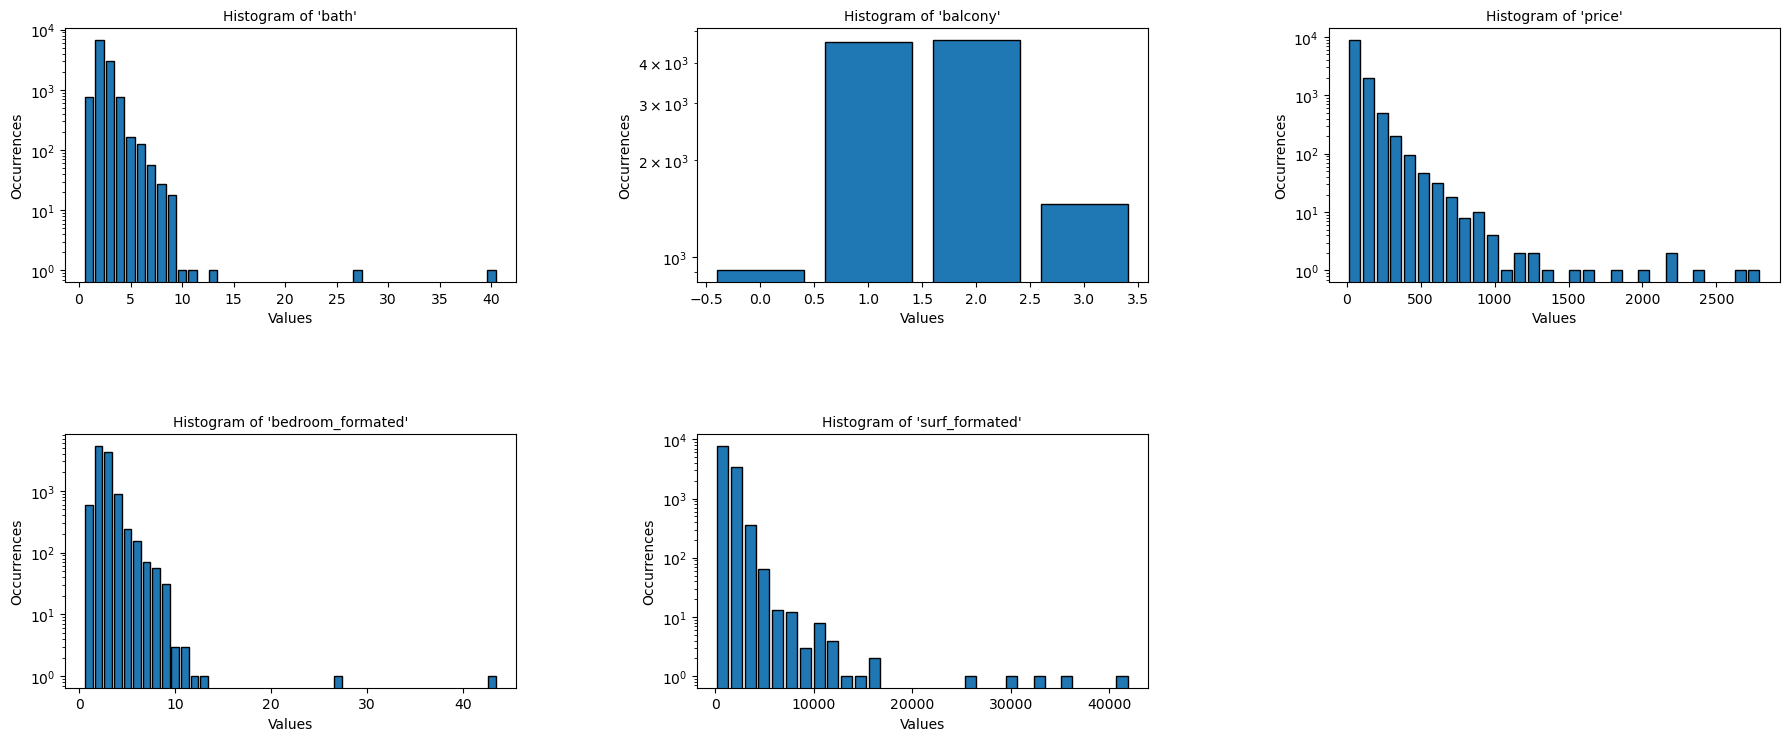

In [59]:
discrete_columns = ['bath', 'balcony', 'bedroom_formated']
continuous_columns = ['price', 'surf_formated']

k = 0
plt.figure(figsize=(18, 12))

for col_name in list_columns_to_visualise:
    k += 1
    plt.subplot(3, 3, k)
    if col_name in discrete_columns:
        min_value = df7[col_name].min()
        max_value = df7[col_name].max()
        bins = np.arange(min_value - 0.5, max_value + 1.5, 1)  
    else:
        bins = 30  # Arbitrarily chosen
    
    plt.hist(df7[col_name], rwidth=0.8, bins=bins, edgecolor='black')
    plt.xlabel('Values')
    plt.ylabel('Occurrences')
    plt.yscale('log')
    plt.title(f"Histogram of '{col_name}'", fontsize=10)

plt.tight_layout()
plt.subplots_adjust(top=0.9, hspace=0.6, wspace=0.4)
plt.show()
